In [1]:
import os
import sys
import pandas as pd
import numpy as np

In [2]:
import funcs
from funcs import fix_ttype_feature

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [4]:
#trainPlusTestSize = 2500
GZ1 = pd.read_csv('data/GalaxyZoo1/GZ1.csv') #Galaxy zoo data from data.galaxyzoo.org (unwanted columns removed)
features = pd.read_csv('data/features/features.csv') 
                #from sciencedirect.com/science/article/pii/S2213133719300757 (unwanted columns removed)
features = features.rename(columns={'dr7objid':'OBJID'})
features = features.drop_duplicates()
df = pd.merge(features, GZ1, on='OBJID', how='inner')
df = df[df.UNCERTAIN==0].drop(columns=['UNCERTAIN']) #remove Uncertain category, i.e. not elliptical nor spiral
df = df[df.Error==0] #Keep successful CyMorph processes only. See kaggle.com/datasets/saurabhshahane/galaxy-classification
df = df[(df['G2']>-6000) & (df['S']>-6000) & (df['A']>-6000) & (df['C']>-6000)] #discard outliers
df = df.drop(['Error'], axis=1) 
df = fix_ttype_feature(df)
#df = df.sample(n=trainPlusTestSize, random_state=1)
df = df.reset_index(drop=True)

/tmp/ipykernel_26688/176806989.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv('data/features/features.csv')


# Distributions

In [5]:
def features_grouped_by_label(df, features=['C', 'A', 'S', 'H', 'G2'], extra_title=''):    
    bins=100
    fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(5, 5*len(features)))
    
    # loop through each feature column and create a histogram for each label
    for i, feature in enumerate(features):
        axs[i].hist(df[df['SPIRAL']==1][feature], bins, density=True, histtype=u'step', label='spiral')
        axs[i].hist(df[df['ELLIPTICAL']==1][feature], bins, density=True, histtype=u'step', label='elliptical')
        #axs[i].hist(df[df['UNCERTAIN']==1][feature], bins, histtype=u'step', label='uncertain')
        axs[i].set_title('feature='+feature + extra_title)
        axs[i].legend(loc='upper center',bbox_to_anchor=(0, 0, 1, 1))
    plt.show()

def single_roc(trueLabels, scores, title):
    fpr, tpr, _ = roc_curve(trueLabels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr,
             tpr,
             color="darkorange",
             lw=lw,
             label="ROC curve (area = %0.2f)" % roc_auc,
            )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [6]:
#features normalized to [0,1]
minK = 5
df_norm = df[df['K']>minK].drop(columns=['OBJID', 'TType'])
df_norm = funcs.normalize_data(df_norm)

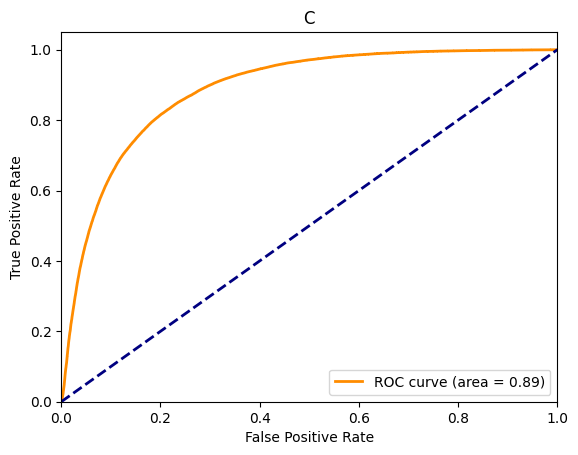

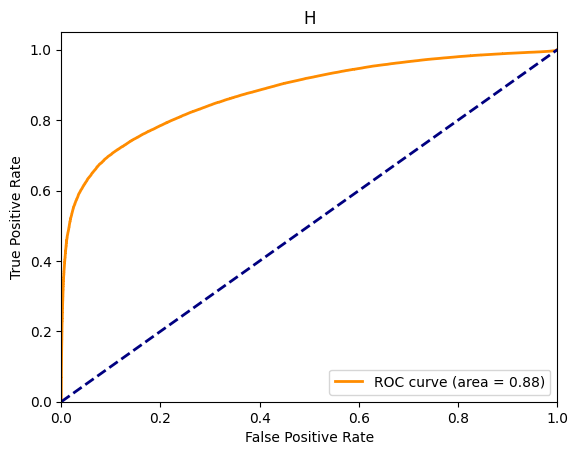

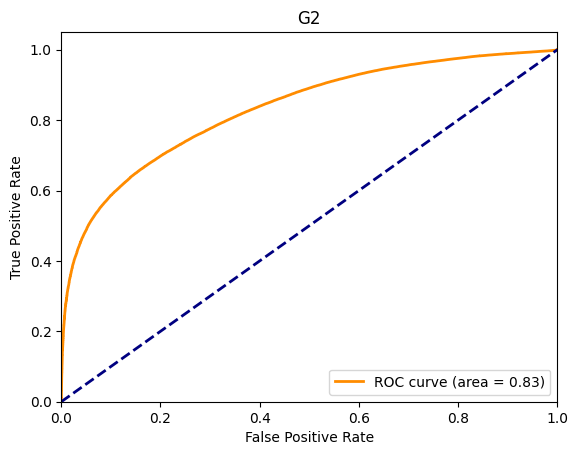

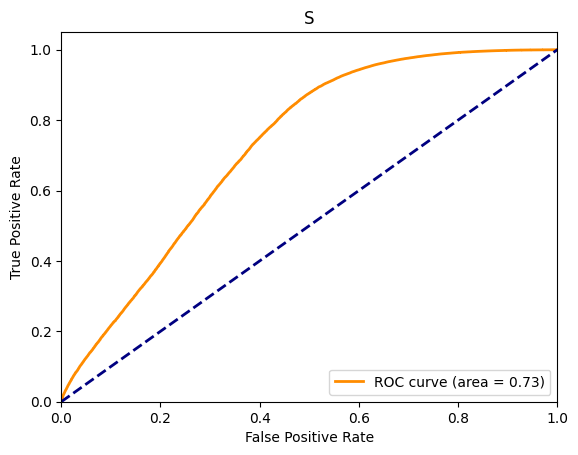

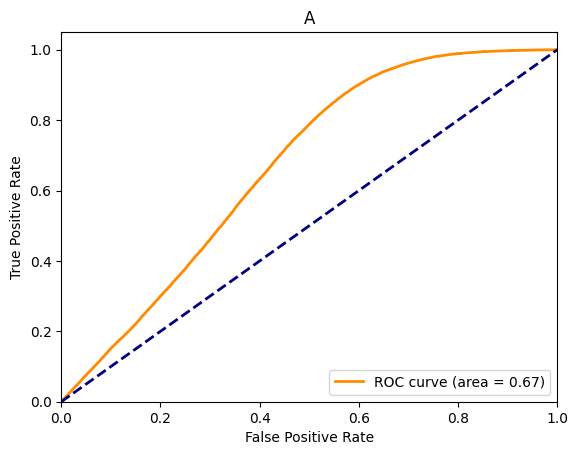

In [10]:
features = ['C', 'H', 'G2', 'S', 'A']

for feature in features:
    trueLabel = 'ELLIPTICAL' if feature in ['C', 'A'] else 'SPIRAL'
    single_roc(df_norm[trueLabel], df_norm[feature], title = feature)

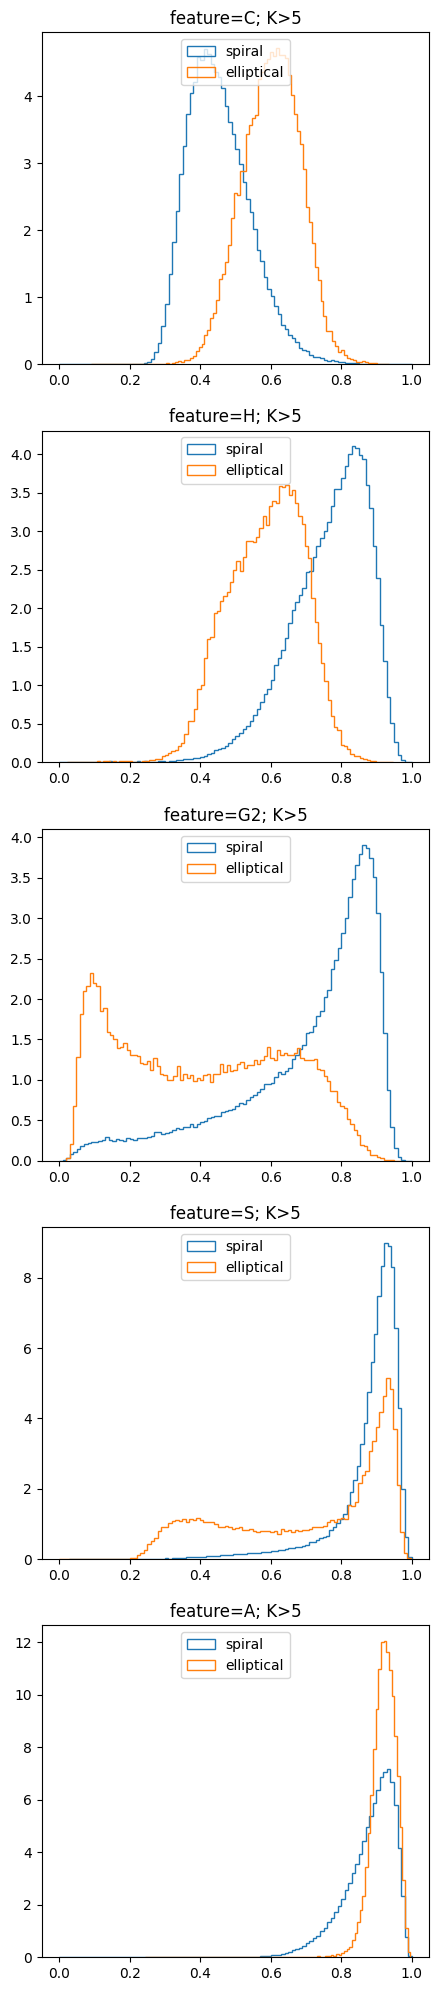

In [12]:
#features normalized to [0,1]
features_grouped_by_label(df_norm, features=features, extra_title='; K>'+str(minK))


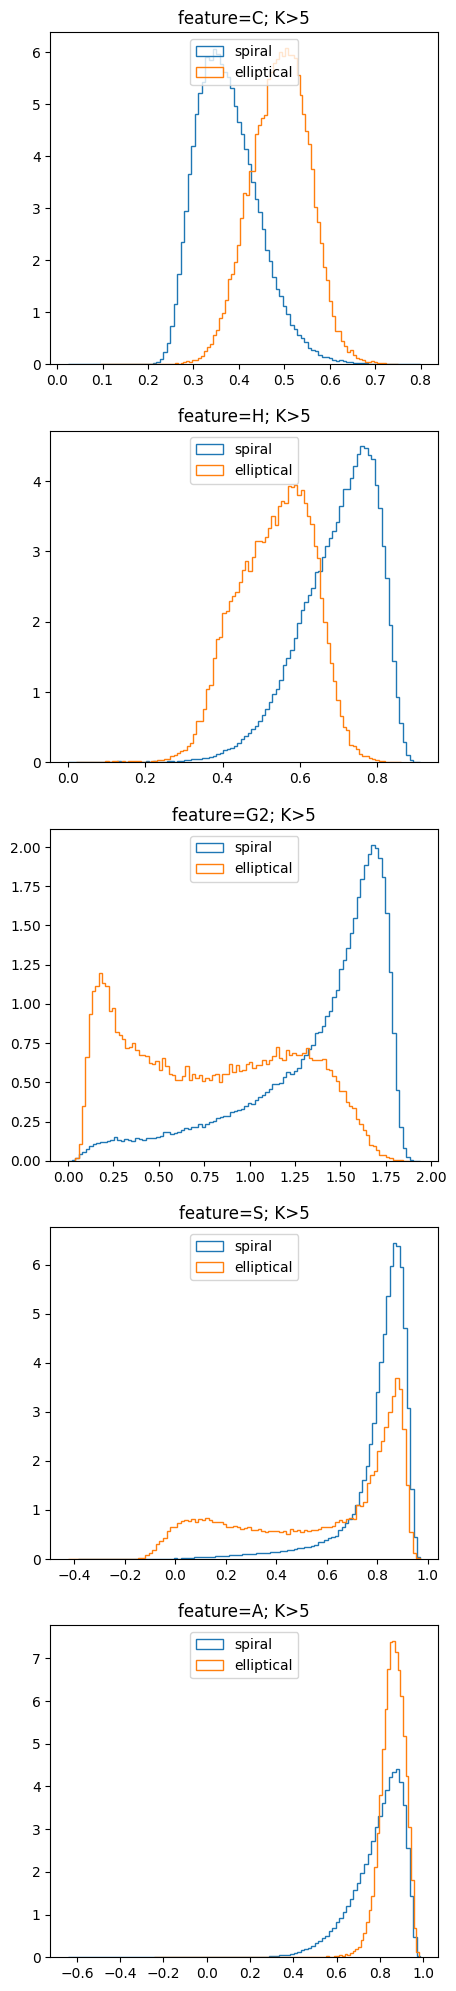

In [13]:
#non-normalized version
minK = 5
features_grouped_by_label(df[df['K']>minK], features=features, extra_title='; K>'+str(minK))


# 2D distributions

In [8]:
import itertools

In [9]:
def features_grouped_by_label_2D(df, features=['C', 'A', 'S', 'H', 'G2'], extra_title=''):
    nDataPointsToPlot = 500
    combs = list(itertools.combinations(features, 2)) #all pairs of features
    fig, axs = plt.subplots(nrows=int(len(combs)/2), ncols=2, figsize=(2*5, int(5*len(combs)/2)))
    markerSize = 6
    alpha = 0.5
    for i, feature_pair in enumerate(combs):
        f1, f2 = feature_pair
        axs[i%5, int(i/5)].scatter(df[f1][df['SPIRAL']==1].iloc[:nDataPointsToPlot], df[f2][df['SPIRAL']==1].iloc[:nDataPointsToPlot], c='blue', s=markerSize, alpha=alpha, label='spiral')
        axs[i%5, int(i/5)].scatter(df[f1][df['SPIRAL']==0].iloc[:nDataPointsToPlot], df[f2][df['SPIRAL']==0].iloc[:nDataPointsToPlot], c='red', s=markerSize, alpha=alpha, label='elliptical')
        #axs[i].set_title(f1+' vs '+f2 + extra_title)
        axs[i%5, int(i/5)].legend(loc='lower center',bbox_to_anchor=(0, 0, 1, 1))
        axs[i%5, int(i/5)].set_xlabel(f1)
        axs[i%5, int(i/5)].set_ylabel(f2)
    plt.show()

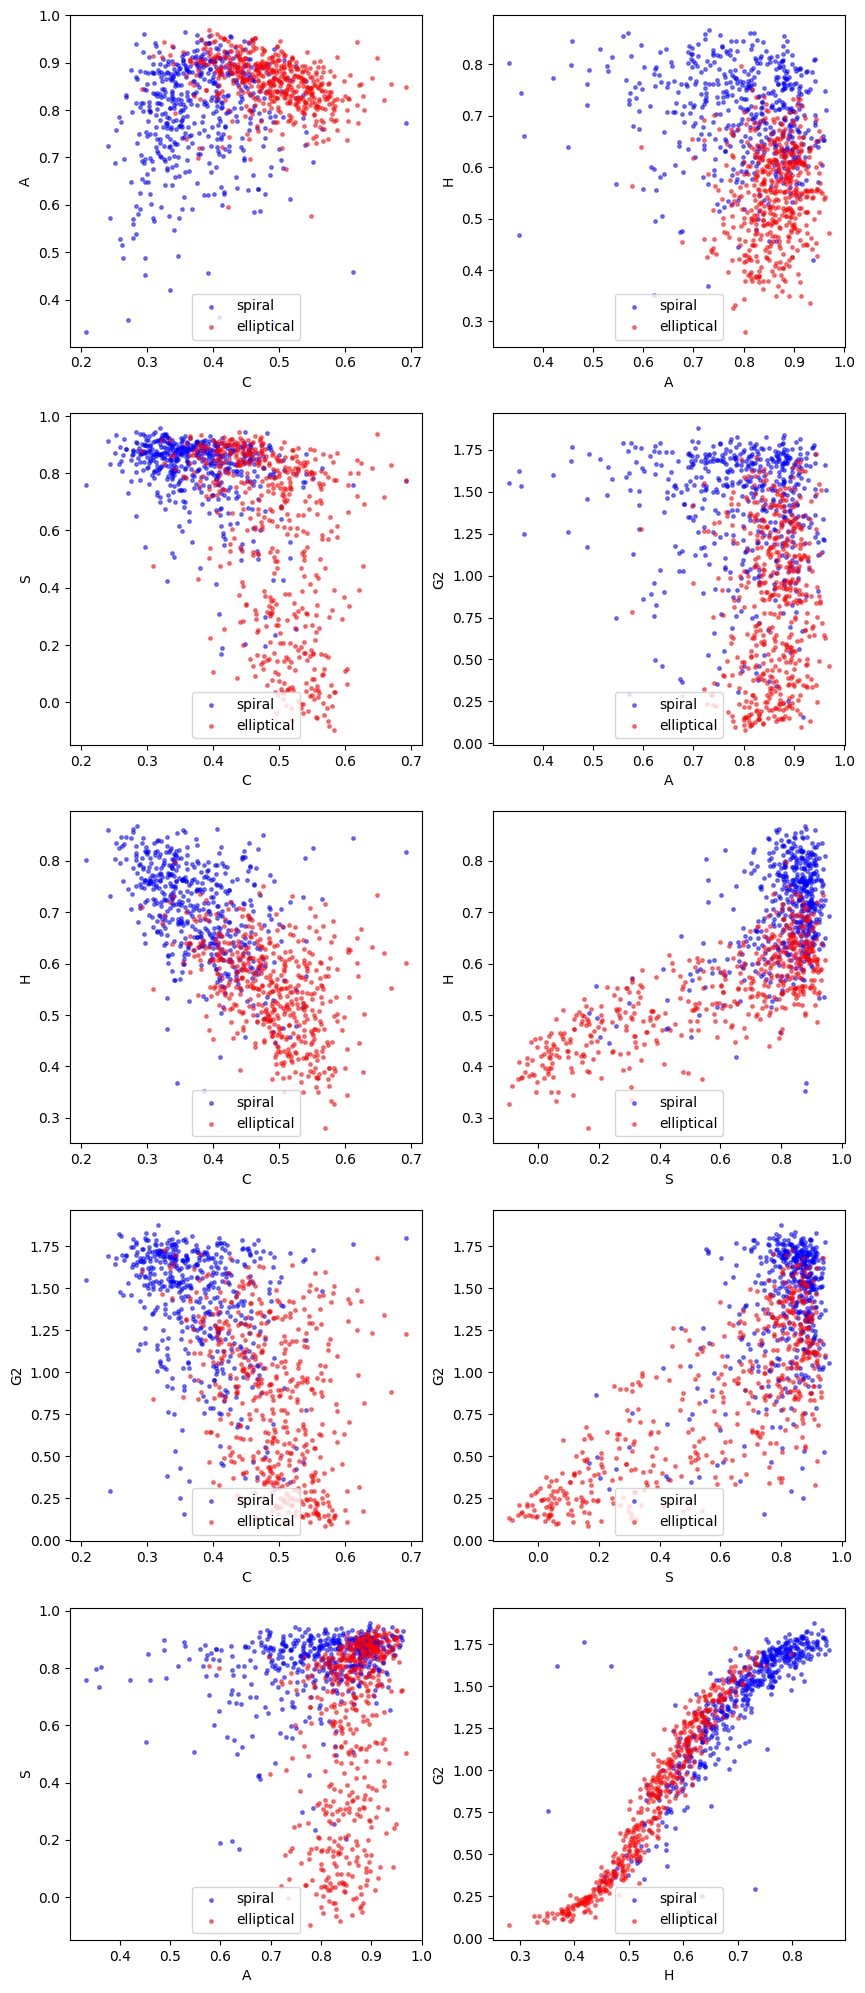

In [11]:
minK=5
features_grouped_by_label_2D(df[df['K']>minK])

# PCA

In [11]:
train_data, train_labels, test_data, test_labels, train_extraInfo, test_extraInfo = funcs.get_train_test(df, n_splits=5, fold_idx=0)


In [12]:
train_data = funcs.normalize_data(train_data)
test_data = funcs.normalize_data(test_data)

In [13]:
n_features = np.shape(train_data)[1]

In [14]:
from sklearn.decomposition import PCA

# Perform PCA on the features
pca = PCA(n_components=2)
pca_features = pca.fit_transform(train_data)

In [15]:
my_list = ['C', 'A', 'S', 'H', 'G2']

# Get all possible pairs of elements from the list
pairs = list(itertools.combinations(my_list, 2))

In [ ]:
# Plot the two most important features, color-coded by their labels
fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(5, 5*len(features)))

nDataPointsToPlot = 5000
fig = plt.figure(figsize=(8, 8))
#colors = ['red' if l == 0 else 'blue' for l in train_labels]
plt.scatter(pca_features[:nDataPointsToPlot,0], pca_features[:nDataPointsToPlot,1], c=train_labels.iloc[:nDataPointsToPlot], s=4, alpha=0.4)
plt.xlabel("PC1")
plt.ylabel("PC2")
#plt.legend(['spiral', 'elliptical'], loc='upper right')
plt.show()
